In [1]:
import torch
import pickle
import yaml
import glob
import imageio
import cv2
import matplotlib.pyplot as plt
import time

from skimage.transform import downscale_local_mean
from marching_cubes_rgb import *
from utils import *

DEFAULT_RENDER_RESOLUTION = 64
# DEFAULT_MAX_MODEL_2_RENDER = 1
DEFAULT_MAX_MODEL_2_RENDER = None
DEFAULT_IMAGES_PER_MODEL = 1

DECODER_PATH = "models_and_codes/decoder.pth"
ENCODER_PATH = "models_and_codes/encoderGrid.pth"
LATENT_CODE_PATH = "models_and_codes/latent_code.pkl"
PARAM_FILE = "config/param_encoder.yaml"
VEHICLE_VALIDATION_PATH = "config/vehicle_validation.txt"
MATRIX_PATH = "../../image2sdf/input_images_validation/matrix_w2c.pkl"
ANNOTATIONS_PATH = "../../image2sdf/input_images_validation/annotations.pkl"
IMAGES_PATH = "../../image2sdf/input_images_validation/images/"
OUTPUT_DIR = "../../image2sdf/encoder_output/evaluation"
LOGS_PATH = "../../image2sdf/logs/encoder/log.pkl"
PLOT_PATH = "../../image2sdf/plots/encoder/"

def init_xyz(resolution):
    xyz = torch.empty(resolution * resolution * resolution, 3).cuda()

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xyz[x * resolution * resolution + y * resolution + z, :] = torch.Tensor([x/(resolution-1)-0.5,y/(resolution-1)-0.5,z/(resolution-1)-0.5])

    return xyz


def load_grid(list_hash, annotations, num_model_2_render, param_image, param_network):

    matrix_world_to_camera = pickle.load(open(MATRIX_PATH, 'rb'))

    num_model = len(list_hash)

    width_image = param_image["width"]
    height_image = param_image["height"]
    width_network = param_network["width"]
    height_network = param_network["height"]
    num_slices = param_network["num_slices"]

    
    all_grid = torch.empty([num_model, num_model_2_render, 3, num_slices, width_network, height_network], dtype=torch.float)

    list_id = list(annotations.keys())

    for model_hash, model_id in zip(list_hash, range(num_model)):
        for image_pth, image_id in zip(glob.glob(IMAGES_PATH + model_hash + '/*'), range(num_model_2_render)):

            # Load data and get label
            image_pth = IMAGES_PATH + model_hash + '/' + str(image_id) + '.png'
            input_im = imageio.imread(image_pth)

            loc_3d = annotations[model_hash][image_id]['3d'].copy()
            frame = annotations[model_hash][image_id]['frame'].copy()

            # interpolate slices vertex coordinates
            loc_slice_3d = np.empty([num_slices,4,3])
            for i in range(num_slices):
                loc_slice_3d[i,0,:] = loc_3d[0,:] * (1-i/(num_slices-1)) + loc_3d[4,:] * i/(num_slices-1)
                loc_slice_3d[i,1,:] = loc_3d[1,:] * (1-i/(num_slices-1)) + loc_3d[5,:] * i/(num_slices-1)
                loc_slice_3d[i,2,:] = loc_3d[2,:] * (1-i/(num_slices-1)) + loc_3d[6,:] * i/(num_slices-1)
                loc_slice_3d[i,3,:] = loc_3d[3,:] * (1-i/(num_slices-1)) + loc_3d[7,:] * i/(num_slices-1)

            # convert to image plane coordinate
            loc_slice_2d = np.empty_like(loc_slice_3d)
            for i in range(num_slices):
                for j in range(4):
                    loc_slice_2d[i,j,:] = convert_w2c(matrix_world_to_camera, frame, loc_slice_3d[i,j,:]) 

            ###### y coordinate is inverted + rescaling #####
            loc_slice_2d[:,:,1] = 1 - loc_slice_2d[:,:,1]
            loc_slice_2d[:,:,0] = loc_slice_2d[:,:,0] * width_image
            loc_slice_2d[:,:,1] = loc_slice_2d[:,:,1] * height_image

            # grid to give as input to the network
            input_grid = np.empty([num_slices, width_network, height_network, 3])


            # fill grid by slices
            for i in range(num_slices):
                src = loc_slice_2d[i,:,:2].copy()
                dst = np.array([[0, height_network], [width_network, height_network], [width_network, 0], [0,0]])
                h, mask = cv2.findHomography(src, dst)
                slice = cv2.warpPerspective(input_im, h, (width_network,height_network))
                input_grid[i,:,:,:] = slice

            # rearange, normalize and convert to tensor
            input_grid = np.transpose(input_grid, [3,0,1,2])
            input_grid = input_grid/255 - 0.5
            input_grid = torch.tensor(input_grid, dtype = torch.float)

            all_grid[model_id, image_id, :, :, :, :] = input_grid

    return all_grid


def get_code_from_grid(grid, latent_size):

    encoder = torch.load(ENCODER_PATH).cuda()
    encoder.eval()

    num_model = grid.shape[0]
    num_images_per_model = grid.shape[1]

    lat_code = torch.empty([num_model, num_images_per_model, latent_size]).cuda()
    for model_id in range(num_model):
        for image_id in range(num_images_per_model):
            lat_code[model_id, image_id, :] = encoder(grid[model_id, image_id, :, :, :, :].unsqueeze(0).cuda()).detach()


    return lat_code





# load parameters
param_all = yaml.safe_load(open(PARAM_FILE))
param = param_all["encoder"]

# load annotations
annotations = pickle.load(open(ANNOTATIONS_PATH, "rb"))
dict_hash_2_code = pickle.load(open(LATENT_CODE_PATH, 'rb'))

# Get validation model
with open(VEHICLE_VALIDATION_PATH) as f:
    list_hash_validation = f.read().splitlines()
list_hash_validation = list(list_hash_validation)

if DEFAULT_MAX_MODEL_2_RENDER is not None:
    list_hash_validation = list_hash_validation[:DEFAULT_MAX_MODEL_2_RENDER]

# only keep the ones for which with have annotated images
list_hash = []
for hash in list_hash_validation:
    if hash in annotations.keys():
        list_hash.append(hash)

num_model = len(list_hash)
num_images_per_model = len(annotations[list_hash[0]])
num_model_2_render= min(num_images_per_model, DEFAULT_IMAGES_PER_MODEL)

resolution = DEFAULT_RENDER_RESOLUTION

# compute latent codes
print("load grid...")
grid = load_grid(list_hash, annotations, num_model_2_render, param["image"], param["network"])
print("compute code from grid...")
latent_code = get_code_from_grid(grid, param_all["latent_size"])


# # fill a xyz grid to give as input to the decoder 
# xyz = init_xyz(resolution)



Using skimage's marching cubes implementation.
load grid...
compute code from grid...


time passed: 0.13162517547607422
time passed: 0.23958325386047363
Average number of iteration needed: 22.448505401611328
Maximum number of iteration needed: 29.0


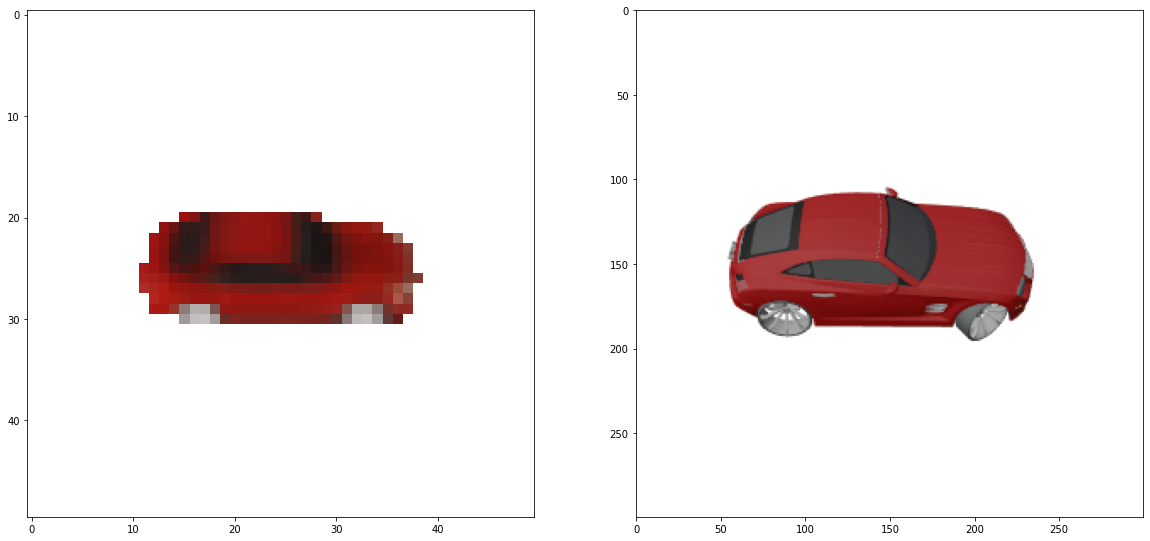

In [345]:

model_id = 3

threshold = 1/64
max_displacement = 0.1
max_iter = 40
resolution = 50

increase_factor = 1

resolution *= increase_factor
increase_factor = increase_factor * increase_factor

# load decoder
decoder = torch.load(DECODER_PATH).cuda()
decoder.eval()

fig, axs = plt.subplots(1,2, figsize=(20,10))
for image_id in range(1):

    model_hash = list_hash[model_id]
    code_prediction = latent_code[model_id,:].squeeze()
    code_gt = dict_hash_2_code[model_hash].cuda()

    frame = annotations[model_hash][image_id]['frame'].copy()
    matrix_object_to_world = annotations[model_hash][image_id]['matrix_object_to_world'].copy()
    matrix_world_to_camera = pickle.load(open(MATRIX_PATH, 'rb'))

    matrix_world_to_camera = matrix_world_to_camera[[1,0,2,3]]
    matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]

    matrix_camera_to_world = np.linalg.inv(matrix_world_to_camera)
    matrix_world_to_object = np.linalg.inv(matrix_object_to_world)

    matrix_camera_to_object = matrix_world_to_object.dot(matrix_camera_to_world)

    image_pth = IMAGES_PATH + model_hash + '/' + str(image_id) + '.png'
    input_im = imageio.imread(image_pth)

    cam_pos_cam_coord = np.array([0,0,0,1])
    cam_pos_obj_coord = matrix_camera_to_object.dot(cam_pos_cam_coord)

    pos_along_ray = torch.ones([resolution * resolution, 3], dtype=torch.float).cuda()
    pos_along_ray[:,0] *= cam_pos_obj_coord[0]
    pos_along_ray[:,1] *= cam_pos_obj_coord[1]
    pos_along_ray[:,2] *= cam_pos_obj_coord[2]

    ray_casting_vector = np.empty([resolution * resolution, 3])

    time_start = time.time()

    for i in range(resolution):
        for j in range(resolution):

            # select pixel to render
            pixel_pos = np.array([i/(resolution-1),j/(resolution-1)])

            # convert pixel in world coordinate
            pixel_pos_cam_coord = convert_view_to_camera_coordinates(frame, pixel_pos)
            pixel_pos_obj_coord = matrix_camera_to_object.dot(pixel_pos_cam_coord)

            ray_casting_vector[i * resolution + j,:] = ((pixel_pos_obj_coord - cam_pos_obj_coord)/np.linalg.norm(pixel_pos_obj_coord - cam_pos_obj_coord))[:3]

    ray_casting_vector = torch.tensor(ray_casting_vector,dtype=torch.float).cuda()

    print(f"time passed: {time.time() - time_start}")
    time_start = time.time()

    rendered_image = np.ones([resolution,resolution,3])
    sdf_and_rgb = torch.empty([resolution * resolution,4], dtype=torch.float).cuda()

    count_iter = torch.zeros(resolution * resolution).cuda()

    # iterate
    for iter in range(max_iter):

        # sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution,1]), pos_along_ray)[:,:].detach()

        for x in range(increase_factor):
            sdf_and_rgb[x * (int)(resolution * resolution / increase_factor) : (x+1) * (int)(resolution * resolution / increase_factor),:] = decoder(code_prediction.unsqueeze(0).repeat([(int)(resolution * resolution / increase_factor), 1]), pos_along_ray[x * (int)(resolution * resolution / increase_factor) : (x+1) * (int)(resolution * resolution / increase_factor)]).detach()
        
        sdf = sdf_and_rgb[:,0]
        sdf = sdf.clamp(None, max_displacement)
        sdf *= 1 # unit of 1 from the decoder's prediction correspond to a unit of 1 in the object coordinate

        sdf_cube, _ = torch.max(abs(pos_along_ray) - 0.5,1) # 0.5 because the car is contained in a cube of length 1
        
        step = sdf
        step[sdf_cube > max_displacement] = sdf_cube[sdf_cube > max_displacement]

        # cube_sdf


        pos_along_ray = pos_along_ray + step.unsqueeze(1).mul(ray_casting_vector)


        count_iter[(sdf < threshold) * (count_iter == 0)] = iter + 1


    sdf_and_rgb = sdf_and_rgb.reshape(resolution, resolution, 4).cpu().numpy()
    sdf = sdf_and_rgb[:,:,0]
    rgb = sdf_and_rgb[:,:,1:]

    rendered_image[sdf < threshold] = rgb[sdf < threshold]


    print(f"time passed: {time.time() - time_start}")
    time_start = time.time()
            
    axs[2 * image_id].imshow(rendered_image)
    # image_downscaled = downscale_local_mean(input_im, (3, 3, 1)).astype(int)
    # axs[2 * image_id + 1].imshow(image_downscaled)
    axs[2 * image_id + 1].imshow(input_im)


print(f"Average number of iteration needed: {count_iter.sum() / count_iter.count_nonzero()}")
print(f"Maximum number of iteration needed: {count_iter.max()}")



In [35]:
model_id = 5

threshold = 1/64
max_displacement = 0.1
max_iter = 40
resolution = 50
# resolution = 100

# load decoder
decoder = torch.load(DECODER_PATH).cuda()
decoder.eval()


model_hash = list_hash[model_id]
# code_prediction = latent_code[model_id,:].squeeze().clone()
code_prediction = torch.zeros(6).cuda()
code_gt = dict_hash_2_code[model_hash].cuda()



optimizer = torch.optim.Adam(
    [
        {
            "params": code_prediction,
            # "params": decoder.parameters(),
            "lr": 0.2,
        },

    ]
)
code_prediction.requires_grad = True

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


In [1]:
nb_image = 3
nb_step = 3


if nb_image * 2 <= 10 and nb_step <= 10:
    fig, axs = plt.subplots(nb_step,nb_image * 2, figsize=(20,10))

for step_id in range(nb_step):
    loss = torch.zeros(1).cuda()
    loss.requires_grad = True
    for image_id in range(nb_image):

        optimizer.zero_grad()

        time_start = time.time()


        frame = annotations[model_hash][image_id]['frame'].copy()
        matrix_object_to_world = annotations[model_hash][image_id]['matrix_object_to_world'].copy()
        matrix_world_to_camera = pickle.load(open(MATRIX_PATH, 'rb'))

        matrix_world_to_camera = matrix_world_to_camera[[1,0,2,3]]
        matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]

        matrix_camera_to_world = np.linalg.inv(matrix_world_to_camera)
        matrix_world_to_object = np.linalg.inv(matrix_object_to_world)

        matrix_camera_to_object = matrix_world_to_object.dot(matrix_camera_to_world)

        image_pth = IMAGES_PATH + model_hash + '/' + str(image_id) + '.png'
        input_im = imageio.imread(image_pth)

        cam_pos_cam_coord = np.array([0,0,0,1])
        cam_pos_obj_coord = matrix_camera_to_object.dot(cam_pos_cam_coord)

        pos_along_ray = torch.ones([resolution * resolution, 3], dtype=torch.float).cuda()
        pos_along_ray[:,0] *= cam_pos_obj_coord[0]
        pos_along_ray[:,1] *= cam_pos_obj_coord[1]
        pos_along_ray[:,2] *= cam_pos_obj_coord[2]

        ray_casting_vector = np.empty([resolution * resolution, 3])

        for i in range(resolution):
            for j in range(resolution):

                # select pixel to render
                pixel_pos = np.array([i/(resolution-1),j/(resolution-1)])

                # convert pixel in world coordinate
                pixel_pos_cam_coord = convert_view_to_camera_coordinates(frame, pixel_pos)
                pixel_pos_obj_coord = matrix_camera_to_object.dot(pixel_pos_cam_coord)

                # compute normed ray marching vector
                ray_casting_vector[i * resolution + j,:] = ((pixel_pos_obj_coord - cam_pos_obj_coord)/np.linalg.norm(pixel_pos_obj_coord - cam_pos_obj_coord))[:3]

        ray_casting_vector = torch.tensor(ray_casting_vector,dtype=torch.float).cuda()


        rendered_image = torch.ones([resolution,resolution,3]).cuda()
        sdf_and_rgb = torch.empty([resolution * resolution,4], dtype=torch.float).cuda()

        # iterate
        for iter in range(max_iter):

            # sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution,1]), pos_along_ray)[:,:]
            sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution,1]), pos_along_ray)[:,:].detach()

            sdf = sdf_and_rgb[:,0]
            sdf = sdf.clamp(None, max_displacement)
            sdf *= 1 # unit of 1 from the decoder's prediction correspond to a unit of 1 in the object coordinate

            sdf_cube, _ = torch.max(abs(pos_along_ray) - 0.5,1) # 0.5 because the car is contained in a cube of length 1
            
            step = sdf
            step[sdf_cube > max_displacement] = sdf_cube[sdf_cube > max_displacement]

            # update ray marching
            pos_along_ray = pos_along_ray + step.unsqueeze(1).mul(ray_casting_vector)

        # compute again and keep the gradient
        sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution,1]), pos_along_ray)[:,:]

        # store results after last iteration
        sdf_and_rgb = sdf_and_rgb.reshape(resolution, resolution, 4)
        sdf = sdf_and_rgb[:,:,0]
        rgb = sdf_and_rgb[:,:,1:]

        # set image where the sdf is close to 0, and rescale between 0 and 255
        weight = sdf < threshold
        rendered_image[weight] = rgb[weight]
        rendered_image = (rendered_image * 255)

        # image_downscaled = downscale_local_mean(input_im, (3, 3, 1)).astype(int)
        image_downscaled = downscale_local_mean(input_im, (6, 6, 1)).astype(int)

        ### lab one day, not differentiable for now
        # image_downscaled_lab = torch.tensor(color.rgb2lab(image_downscaled/255))
        # rendered_image_lab = torch.tensor(color.rgb2lab(rendered_image.cpu().detach().numpy()/255)).cuda()
        # loss_image = (abs(rendered_image_lab - torch.tensor(image_downscaled_lab).cuda()) * weight.unsqueeze(2).expand(50,50,3)).mean()

        loss_image = (abs(rendered_image - torch.tensor(image_downscaled).cuda()) * weight.unsqueeze(2).expand(50,50,3)).mean()
        loss = loss + loss_image

        # tranfer to cpu
        rendered_image = rendered_image.cpu().detach().numpy().astype(int)

        # show time passed
        # print(f"time passed: {time.time() - time_start}")
        
        # plot

        if nb_image * 2 <= 10 and nb_step <= 10:
            axs[step_id, 2 * image_id].imshow(rendered_image)
            axs[step_id, 2 * image_id + 1].imshow(image_downscaled)



    loss.backward()


    optimizer.step()
    scheduler.step()
    
    print(f"step {step_id}, loss: {loss.item()}")
    print(f"distance to ground truth code: {(code_prediction - latent_code[model_id,:].squeeze()).norm().item()}")




NameError: name 'plt' is not defined

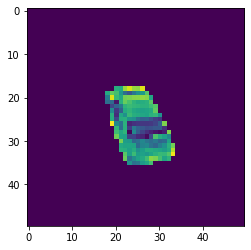

In [33]:
plt.imshow((abs(torch.tensor(rendered_image).cuda() - torch.tensor(image_downscaled).cuda()) * weight.unsqueeze(2).expand(50,50,3)).sum(2).cpu().numpy())

In [8]:
xyz = init_xyz(64)
rendering_resolution = 64

In [2]:
# variable to store results
sdf_result = np.empty([rendering_resolution, rendering_resolution, rendering_resolution, 4])

# loop because it requires too much GPU memory on my computer
for x in range(rendering_resolution):
    code = code_prediction.repeat(rendering_resolution * rendering_resolution, 1).cuda()
    xyz_sub_sample = xyz[x * rendering_resolution * rendering_resolution: (x+1) * rendering_resolution * rendering_resolution]

    sdf_pred = decoder(code, xyz_sub_sample).detach().cpu()
    sdf_pred[:,0] = sdf_pred[:,0] * rendering_resolution
    sdf_pred[:,1:] = torch.clamp(sdf_pred[:,1:], 0, 1)

    sdf_pred[:,1:] = sdf_pred[:,1:] * 255

    sdf_result[x, :, :, :] = np.reshape(sdf_pred[:,:], [rendering_resolution, rendering_resolution, 4])

# print('Minimum and maximum value: %f and %f. ' % (np.min(sdf_result[:,:,:,0]), np.max(sdf_result[:,:,:,0])))
if(np.min(sdf_result[:,:,:,0]) < 0 and np.max(sdf_result[:,:,:,0]) > 0):
    vertices_pred, faces_pred = marching_cubes(sdf_result[:,:,:,0])
    colors_v_pred = exctract_colors_v(vertices_pred, sdf_result)
    colors_f_pred = exctract_colors_f(colors_v_pred, faces_pred)
    off_file = "../../image2sdf/test/test.off"
    write_off(off_file, vertices_pred, faces_pred, colors_f_pred)
    print("Wrote test.off")
else:
    print("surface level: 0, should be comprise in between the minimum and maximum value")


NameError: name 'rendering_resolution' is not defined

In [212]:
list_hash = list(annotations.keys())

In [10]:
import torch
import pickle
import imageio
import cv2
import matplotlib.pyplot as plt
import time
import numpy as np

from skimage.transform import downscale_local_mean
from utils import *

DECODER_PATH = "models_and_codes/decoder.pth"
LATENT_CODE_PATH = "models_and_codes/latent_code.pkl"
ANNOTATIONS_PATH = "../../img_supervision/input_images_validation/annotations.pkl"
IMAGES_PATH = "../../img_supervision/input_images_validation/images/"
MATRIX_PATH = "../../img_supervision/input_images_validation/matrix_w2c.pkl"

RAY_MARCHING_RESOLUTION = 50

BOUND_MAX_CUBE = 0.5
BOUND_MIN_CUBE = -0.5
THRESHOLD = 1/64
MAX_STEP = 1/16
MAX_ITER = 20
SCALING_FACTOR = 2

annotations = pickle.load(open(ANNOTATIONS_PATH, "rb"))
dict_hash_2_code = pickle.load(open(LATENT_CODE_PATH, 'rb'))
decoder = torch.load(DECODER_PATH).cuda()
decoder.eval()

def get_camera_matrix_and_frame(model_hash, image_id, annotations):
    frame = annotations[model_hash][image_id]['frame'].copy()
    matrix_object_to_world = annotations[model_hash][image_id]['matrix_object_to_world'].copy()
    matrix_world_to_camera = annotations["matrix_world_to_camera"]

    matrix_world_to_camera = matrix_world_to_camera[[1,0,2,3]]
    matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]

    matrix_camera_to_world = np.linalg.inv(matrix_world_to_camera)
    matrix_world_to_object = np.linalg.inv(matrix_object_to_world)

    matrix_camera_to_object = matrix_world_to_object.dot(matrix_camera_to_world)

    return frame, matrix_camera_to_object

def initialize_rendering(model_hash, image_id, annotations, image_path):

    image_pth = image_path + model_hash + '/' + str(image_id) + '.png'
    ground_truth_image = imageio.imread(image_pth)/255

    resolution = RAY_MARCHING_RESOLUTION

    frame, matrix_camera_to_object = get_camera_matrix_and_frame(model_hash, image_id, annotations)

    cam_pos_cam_coord = np.array([0,0,0,1])
    cam_pos_obj_coord = matrix_camera_to_object.dot(cam_pos_cam_coord)

    pos_init_ray = np.ones([resolution * resolution, 3])
    pos_init_ray[:,0] *= cam_pos_obj_coord[0]
    pos_init_ray[:,1] *= cam_pos_obj_coord[1]
    pos_init_ray[:,2] *= cam_pos_obj_coord[2]

    ray_marching_vector = np.empty([resolution * resolution, 3])

    for i in range(resolution):
        for j in range(resolution):

            # select pixel to render
            pixel_pos = np.array([i/(resolution-1),j/(resolution-1)])

            # convert pixel in world coordinate
            pixel_pos_cam_coord = convert_view_to_camera_coordinates(frame, pixel_pos)
            pixel_pos_obj_coord = matrix_camera_to_object.dot(pixel_pos_cam_coord)

            ray_marching_vector[i * resolution + j,:] = ((pixel_pos_obj_coord - cam_pos_obj_coord)/np.linalg.norm(pixel_pos_obj_coord - cam_pos_obj_coord))[:3]


    min_step = np.zeros([resolution * resolution, 3])
    max_step = np.ones([resolution * resolution, 3]) * 1e38

    min_step[ray_marching_vector > 0] = (BOUND_MIN_CUBE - pos_init_ray[ray_marching_vector > 0]) / ray_marching_vector[ray_marching_vector > 0]
    min_step[ray_marching_vector < 0] = (BOUND_MAX_CUBE - pos_init_ray[ray_marching_vector < 0]) / ray_marching_vector[ray_marching_vector < 0]

    max_step[ray_marching_vector > 0] = (BOUND_MAX_CUBE - pos_init_ray[ray_marching_vector > 0]) / ray_marching_vector[ray_marching_vector > 0]
    max_step[ray_marching_vector < 0] = (BOUND_MIN_CUBE - pos_init_ray[ray_marching_vector < 0]) / ray_marching_vector[ray_marching_vector < 0]

    max_step[(ray_marching_vector == 0) * ~((pos_init_ray > BOUND_MIN_CUBE) * (pos_init_ray < BOUND_MAX_CUBE))] = 0

    min_step = min_step.max(1)
    max_step = max_step.min(1)

    max_step[min_step >= max_step] = 0
    min_step[min_step >= max_step] = 0



    return ground_truth_image, pos_init_ray, ray_marching_vector, min_step, max_step

def ray_marching_rendering(decoder, latent_code, pos_init_ray, ray_marching_vector, min_step, max_step):

    resolution = RAY_MARCHING_RESOLUTION

    # convert into cuda tensor
    ray_marching_vector = torch.tensor(ray_marching_vector,dtype=torch.float).cuda()
    pos_init_ray = torch.tensor(pos_init_ray,dtype=torch.float).cuda()
    min_step = torch.tensor(min_step,dtype=torch.float).cuda()
    max_step = torch.tensor(max_step,dtype=torch.float).cuda()

    # marching safely until the "cube" representing the zone where the sdf was trained, and therefore contain the whole object
    min_pos = pos_init_ray + min_step.unsqueeze(1).mul(ray_marching_vector)
    pos_along_ray = min_pos
    sum_step = min_step

    ### max pos not used, function ca be improved to stop computing sdf after max pos is reached
    # max_pos = pos_init_ray + max_step.unsqueeze(1).mul(ray_marching_vector)

    # only compute ray marching for ray passing through the cube
    mask_cube = (min_step != 0)
    mask_ray_still_marching = mask_cube

    # define ratio to accelerate ray marching
    ratio = torch.ones([resolution * resolution]).cuda()
    sdf = torch.zeros([resolution * resolution]).cuda()

    for iter in range(MAX_ITER):
        # compute sdf values
        sdf[mask_ray_still_marching] = decoder(latent_code.unsqueeze(0).repeat([mask_ray_still_marching.count_nonzero(),1]), pos_along_ray[mask_ray_still_marching])[:,0].detach()

        # scaling: unit of 1 from the decoder's prediction correspond to a unit of 1 in the object coordinate
        sdf *= 1

        # compute the ratio using difference between old an new sdf values,
        if iter == 0:
            # store first sdf
            old_sdf = sdf
        else:
            # only compute ratio when the sdf is high enough and decreasing
            mask_ratio = (sdf > THRESHOLD) * (sdf < old_sdf)
            ratio[mask_ratio] = old_sdf[mask_ratio]/(old_sdf[mask_ratio] - sdf[mask_ratio])

            # store new sdf
            old_sdf[mask_ray_still_marching] = sdf[mask_ray_still_marching]
            
            # accelarating the step, this is only possible because the decoder tends to underestimate the distance due to the design of the loss
            sdf[mask_ratio] *= ratio[mask_ratio]

        # clamp value to prevent undesired issues
        sdf = sdf.clamp(None, MAX_STEP)

        # march along the ray
        step = sdf
        sum_step += step
        pos_along_ray = pos_along_ray + step.unsqueeze(1).mul(ray_marching_vector)

        mask_ray_still_marching = mask_ray_still_marching * (sum_step < max_step)

    # interpolate final position for a higher resolution
    pos_along_ray = pos_along_ray.reshape(resolution, resolution, 3).permute(2,0,1).unsqueeze(0)
    pos_along_ray = torch.nn.functional.interpolate(pos_along_ray, scale_factor = SCALING_FACTOR, mode='bilinear', align_corners=False)
    pos_along_ray = pos_along_ray.squeeze().permute(1,2,0).reshape(resolution * resolution * SCALING_FACTOR * SCALING_FACTOR, 3)

    # compute corresponding sdf
    sdf_and_rgb = decoder(latent_code.unsqueeze(0).repeat([resolution * resolution * SCALING_FACTOR * SCALING_FACTOR,1]), pos_along_ray)[:,:].detach()
    sdf_and_rgb = sdf_and_rgb.reshape(resolution * SCALING_FACTOR, resolution * SCALING_FACTOR, 4)
    sdf = sdf_and_rgb[:,:,0]
    rgb = sdf_and_rgb[:,:,1:]

    # init image with white background
    rendered_image = torch.ones([resolution * SCALING_FACTOR, resolution * SCALING_FACTOR,3]).cuda()

    mask_car = sdf < THRESHOLD
    rendered_image[mask_car] = rgb[mask_car]

    return rendered_image, mask_car

0.20020508766174316


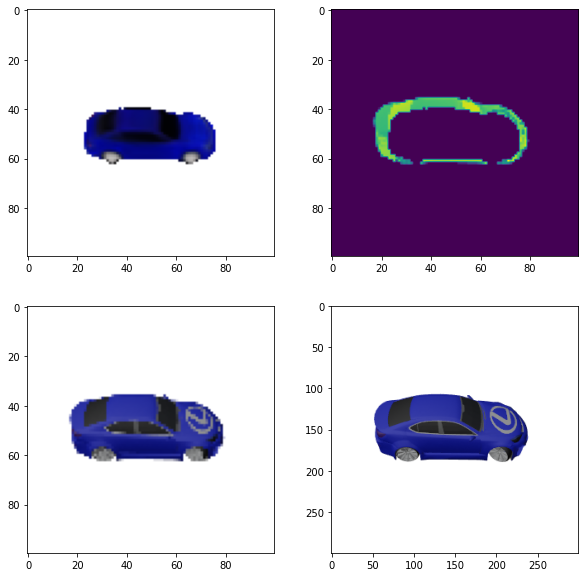

In [64]:
model_id = 3
image_id = 0

list_hash = list(annotations.keys())
model_hash = list_hash[model_id]
code_gt = dict_hash_2_code[model_hash].cuda()

time_start = time.time()
ground_truth_image, pos_init_ray, ray_marching_vector, min_step, max_step = initialize_rendering(model_hash, image_id, annotations, IMAGES_PATH)
ground_truth_image = np.array(ground_truth_image)

rendered_image, mask_car = ray_marching_rendering(decoder, code_gt, pos_init_ray, ray_marching_vector, min_step, max_step)
rendered_image[0,0,0].cpu()

print(time.time() - time_start)


rendered_image = rendered_image.cpu().numpy()
mask_car = mask_car.cpu().numpy()
downscale_ground_truth_image = cv2.resize(ground_truth_image, rendered_image.shape[:2])
error = np.zeros([100, 100, 3])
error[mask_car == False] = abs(downscale_ground_truth_image[mask_car == False] - rendered_image[mask_car == False])
error = error.mean(2)

fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].imshow(rendered_image)
axs[0,1]. imshow(error)
axs[1,0]. imshow(downscale_ground_truth_image)
axs[1,1].imshow(ground_truth_image)



In [339]:

model_id = 3
image_id = 4

threshold = 1/64
max_displacement = 1/16
max_iter = 20
resolution = 50

scale_factor = 2

# load decoder
decoder = torch.load(DECODER_PATH).cuda()
decoder.eval()


model_hash = list_hash[model_id]
# code_prediction = latent_code[model_id,:].squeeze()
code_gt = dict_hash_2_code[model_hash].cuda()
code_prediction = code_gt

frame = annotations[model_hash][image_id]['frame'].copy()
matrix_object_to_world = annotations[model_hash][image_id]['matrix_object_to_world'].copy()
matrix_world_to_camera = pickle.load(open(MATRIX_PATH, 'rb'))

matrix_world_to_camera = matrix_world_to_camera[[1,0,2,3]]
matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]

matrix_camera_to_world = np.linalg.inv(matrix_world_to_camera)
matrix_world_to_object = np.linalg.inv(matrix_object_to_world)

matrix_camera_to_object = matrix_world_to_object.dot(matrix_camera_to_world)

image_pth = IMAGES_PATH + model_hash + '/' + str(image_id) + '.png'
input_im = imageio.imread(image_pth)

cam_pos_cam_coord = np.array([0,0,0,1])
cam_pos_obj_coord = matrix_camera_to_object.dot(cam_pos_cam_coord)

pos_init_ray = np.ones([resolution * resolution, 3])
pos_init_ray[:,0] *= cam_pos_obj_coord[0]
pos_init_ray[:,1] *= cam_pos_obj_coord[1]
pos_init_ray[:,2] *= cam_pos_obj_coord[2]

ray_casting_vector = np.empty([resolution * resolution, 3])

time_start = time.time()

min_step_all = np.zeros([resolution * resolution])
max_step_all = np.zeros([resolution * resolution])

for i in range(resolution):
    for j in range(resolution):

        # select pixel to render
        pixel_pos = np.array([i/(resolution-1),j/(resolution-1)])

        # convert pixel in world coordinate
        pixel_pos_cam_coord = convert_view_to_camera_coordinates(frame, pixel_pos)
        pixel_pos_obj_coord = matrix_camera_to_object.dot(pixel_pos_cam_coord)

        direction = ((pixel_pos_obj_coord - cam_pos_obj_coord)/np.linalg.norm(pixel_pos_obj_coord - cam_pos_obj_coord))[:3]
        ray_casting_vector[i * resolution + j,:] = direction

        bound_max_cube = 0.5
        bound_min_cube = -0.5

        min_step = 0
        max_step = 1e38

        for xyz in range(3):
            if direction[xyz] > 0:
                max = (bound_max_cube - pos_init_ray[i * resolution + j, xyz]) / direction[xyz]
                min = (bound_min_cube - pos_init_ray[i * resolution + j, xyz]) / direction[xyz]

            elif direction[xyz] < 0:
                min = (bound_max_cube - pos_init_ray[i * resolution + j, xyz]) / direction[xyz]
                max = (bound_min_cube - pos_init_ray[i * resolution + j, xyz]) / direction[xyz]
            else:
                if pos_init_ray[i * resolution + j, xyz] < bound_min_cube or pos_init_ray[i * resolution + j, xyz] > bound_max_cube:
                    max = 0

            if min > min_step:
                min_step = min
            if max < max_step:
                max_step = max

        if min_step < max_step:
            min_step_all[i * resolution + j] = min_step
            max_step_all[i * resolution + j] = max_step


1/0


print(f"time for initialization: {time.time() - time_start}")
time_start = time.time()

ray_casting_vector = torch.tensor(ray_casting_vector,dtype=torch.float).cuda()
pos_init_ray = torch.tensor(pos_init_ray,dtype=torch.float).cuda()
min_step_all = torch.tensor(min_step_all,dtype=torch.float).cuda()
max_step_all = torch.tensor(max_step_all,dtype=torch.float).cuda()

min_pos = pos_init_ray + min_step_all.unsqueeze(1).mul(ray_casting_vector)
max_pos = pos_init_ray + max_step_all.unsqueeze(1).mul(ray_casting_vector)

pos_along_ray = min_pos

### first sdf iterartion
sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution,1]), pos_along_ray)[:,:].detach()
sdf = sdf_and_rgb[:,0]
sdf *= 1 # scaling: unit of 1 from the decoder's prediction correspond to a unit of 1 in the object coordinate
old_sdf = sdf
sdf = sdf.clamp(None, max_displacement)
step = sdf

pos_along_ray = pos_along_ray + step.unsqueeze(1).mul(ray_casting_vector)

count_iter = torch.zeros([resolution * resolution]).cuda()

cube_mask = (min_step_all != 0)

sdf = torch.zeros([resolution * resolution]).cuda()

# iterate
for iter in range(max_iter):

    # sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution,1]), pos_along_ray)[:,:].detach()
    sdf[cube_mask] = decoder(code_prediction.unsqueeze(0).repeat([cube_mask.count_nonzero(),1]), pos_along_ray[cube_mask])[:,0].detach()

    sdf *= 1 # unit of 1 from the decoder's prediction correspond to a unit of 1 in the object coordinate

    ratio = torch.ones([resolution * resolution]).cuda()
    ratio[(sdf > threshold) * (sdf < old_sdf)] = old_sdf[(sdf > threshold) * (sdf < old_sdf)]/(old_sdf[(sdf > threshold) * (sdf < old_sdf)] - sdf[(sdf > threshold) * (sdf < old_sdf)])
    old_sdf = sdf
    sdf[sdf > threshold] *= ratio[sdf > threshold] # accelarating the step, this is only possible because the decoder tends to underestimate the distance due to the design of the loss

    sdf = sdf.clamp(None, max_displacement)
    step = sdf

    pos_along_ray = pos_along_ray + step.unsqueeze(1).mul(ray_casting_vector)

    count_iter[(sdf < threshold) * (count_iter == 0)] = iter + 1



# pos_along_ray = pos_along_ray.reshape(resolution, resolution, 3).permute(2,0,1).unsqueeze(0)
# pos_along_ray = torch.nn.functional.interpolate(pos_along_ray, scale_factor = scale_factor)
# pos_along_ray = pos_along_ray.squeeze().permute(1,2,0).reshape(resolution * resolution * scale_factor *scale_factor, 3)

sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution,1]), pos_along_ray)[:,:].detach()
# sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution * scale_factor * scale_factor,1]), pos_along_ray)[:,:].detach()
car_mask = sdf_and_rgb[:,0] < threshold

sdf_and_rgb = sdf_and_rgb.reshape(resolution, resolution, 4).cpu().numpy()
# sdf_and_rgb = sdf_and_rgb.reshape(resolution *scale_factor, resolution * scale_factor, 4).cpu().numpy()
sdf = sdf_and_rgb[:,:,0]
rgb = sdf_and_rgb[:,:,1:]

rendered_image = np.ones([resolution,resolution,3])
# rendered_image = np.ones([resolution * scale_factor, resolution * scale_factor,3])
rendered_image[sdf < threshold] = rgb[sdf < threshold]

### to show the cube
# cube_mask = min_step_all.reshape(resolution, resolution).cpu().numpy() == 0
# rendered_image[cube_mask] = np.zeros(3)

renedered_image_upscaled = cv2.resize(rendered_image, (250,250))
input_im_downscaled = cv2.resize(input_im, (100,100))
        

pos_along_ray = pos_along_ray.reshape(resolution, resolution, 3).permute(2,0,1).unsqueeze(0)
pos_along_ray = torch.nn.functional.interpolate(pos_along_ray, scale_factor = scale_factor, mode='bilinear')
pos_along_ray = pos_along_ray.squeeze().permute(1,2,0).reshape(resolution * resolution * scale_factor *scale_factor, 3)

sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution * scale_factor * scale_factor,1]), pos_along_ray)[:,:].detach()
car_mask = sdf_and_rgb[:,0] < threshold

# sdf_and_rgb = sdf_and_rgb.reshape(resolution, resolution, 4).cpu().numpy()
sdf_and_rgb = sdf_and_rgb.reshape(resolution *scale_factor, resolution * scale_factor, 4).cpu().numpy()
sdf = sdf_and_rgb[:,:,0]
rgb = sdf_and_rgb[:,:,1:]

# rendered_image = np.ones([resolution,resolution,3])
rendered_image = np.ones([resolution * scale_factor, resolution * scale_factor,3])
rendered_image[sdf < threshold] = rgb[sdf < threshold]


# save = rendered_image

# ray_casting_vector = ray_casting_vector.reshape(resolution, resolution, 3).permute(2,0,1).unsqueeze(0)
# ray_casting_vector = torch.nn.functional.interpolate(ray_casting_vector, scale_factor = scale_factor, mode='bilinear')
# ray_casting_vector = ray_casting_vector.squeeze().permute(1,2,0).reshape(resolution * resolution * scale_factor *scale_factor, 3)

# # iterate
# for iter in range(5):

#     sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution * scale_factor * scale_factor,1]), pos_along_ray)[:,:].detach()

#     sdf = sdf_and_rgb[:,0]
#     sdf *= 1 # unit of 1 from the decoder's prediction correspond to a unit of 1 in the object coordinate
#     sdf = sdf.clamp(None, max_displacement)
#     step = sdf

#     pos_along_ray = pos_along_ray + step.unsqueeze(1).mul(ray_casting_vector)

# sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution * scale_factor * scale_factor,1]), pos_along_ray)[:,:].detach()
# car_mask = sdf_and_rgb[:,0] < threshold

# # sdf_and_rgb = sdf_and_rgb.reshape(resolution, resolution, 4).cpu().numpy()
# sdf_and_rgb = sdf_and_rgb.reshape(resolution *scale_factor, resolution * scale_factor, 4).cpu().numpy()
# sdf = sdf_and_rgb[:,:,0]
# rgb = sdf_and_rgb[:,:,1:]

# # rendered_image = np.ones([resolution,resolution,3])
# rendered_image = np.ones([resolution * scale_factor, resolution * scale_factor,3])
# rendered_image[sdf < threshold] = rgb[sdf < threshold]


print(f"time for rendering: {time.time() - time_start}")
time_start = time.time()

fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].imshow(rendered_image)

# axs[0,1].imshow(renedered_image_upscaled)
axs[0,1].imshow(input_im_downscaled)
axs[1,1].imshow(input_im)
axs[1,0].imshow(rendered_image)

# axs[0,1].imshow(save)
# input_im_downscaled[rendered_image == 1] = 255
# axs[1,1].imshow(abs(rendered_image * 255 - input_im_downscaled).mean(2)/255)

print(f"Average number of iteration needed: {count_iter.sum() / count_iter.count_nonzero()}")
print(f"Maximum number of iteration needed: {count_iter.max()}")
print(f"pixel mask of the car: {car_mask.count_nonzero()}")





ZeroDivisionError: division by zero

In [366]:

min = np.zeros([resolution * resolution, 3])
max = np.ones([resolution * resolution, 3]) * 1e38

min[ray_casting_vector > 0] = (BOUND_MIN_CUBE - pos_init_ray[ray_casting_vector > 0]) / ray_casting_vector[ray_casting_vector > 0]
min[ray_casting_vector < 0] = (BOUND_MAX_CUBE - pos_init_ray[ray_casting_vector < 0]) / ray_casting_vector[ray_casting_vector < 0]

max[ray_casting_vector > 0] = (BOUND_MAX_CUBE - pos_init_ray[ray_casting_vector > 0]) / ray_casting_vector[ray_casting_vector > 0]
max[ray_casting_vector < 0] = (BOUND_MIN_CUBE - pos_init_ray[ray_casting_vector < 0]) / ray_casting_vector[ray_casting_vector < 0]

max[(ray_casting_vector == 0) * ~((pos_init_ray > BOUND_MIN_CUBE) * (pos_init_ray < BOUND_MAX_CUBE))] = 0

min = min.max(1)
max = max.min(1)

max[min >= max] = 0
min[min >= max] = 0

In [367]:
max[min >= max] = 0
min[min >= max] = 0

In [352]:
np.unique(min_step < max_step)

array([False,  True])

In [370]:
np.array(np.where(max == save2)).shape

(1, 2500)

In [313]:
save = min

In [304]:
max[ray_marching_vector < 0].shape

(6250,)

In [322]:
max_step

1.012888730091416

In [321]:
np.unique(max_step)

array([1.01288873])

In [273]:
np.array(np.where(test1 == min_step_all)).shape

(1, 547)

In [285]:
(ray_marching_vector < 0).shape

(2500, 3)

In [40]:
cube_mask.count_nonzero()

tensor(547, device='cuda:0')

In [33]:
test = pos_along_ray[:2500]

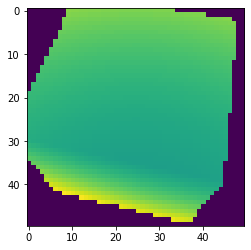

In [41]:
plt.imshow(min_step_all.reshape(resolution, resolution).cpu().numpy())

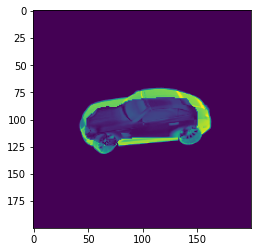

In [86]:
plt.imshow(abs(rendered_image * 255 - input_im_downscaled).mean(2)/255)

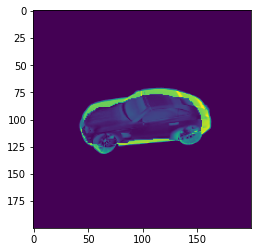

In [88]:
plt.imshow(abs(rendered_image * 255 - input_im_downscaled).mean(2)/255)

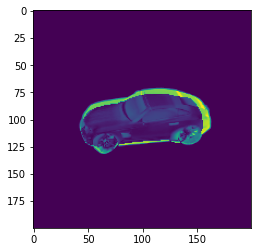

In [83]:
plt.imshow(abs(rendered_image * 255 - input_im_downscaled).mean(2)/255)

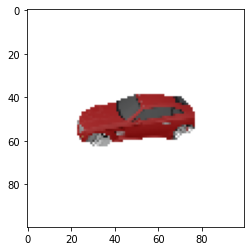

In [74]:
plt.imshow(input_im_downscaled)

In [136]:
test = test.permute(2,0,1)
test.shape

torch.Size([3, 50, 50])

In [61]:
(sdf[sdf > threshold] * ratio).max()

tensor(28.8213, device='cuda:0')

In [53]:
ratio.min()

tensor(1., device='cuda:0')

time for initialization: 0.20121240615844727
time for rendering: 0.41420578956604004
pixel mask of the car: 240


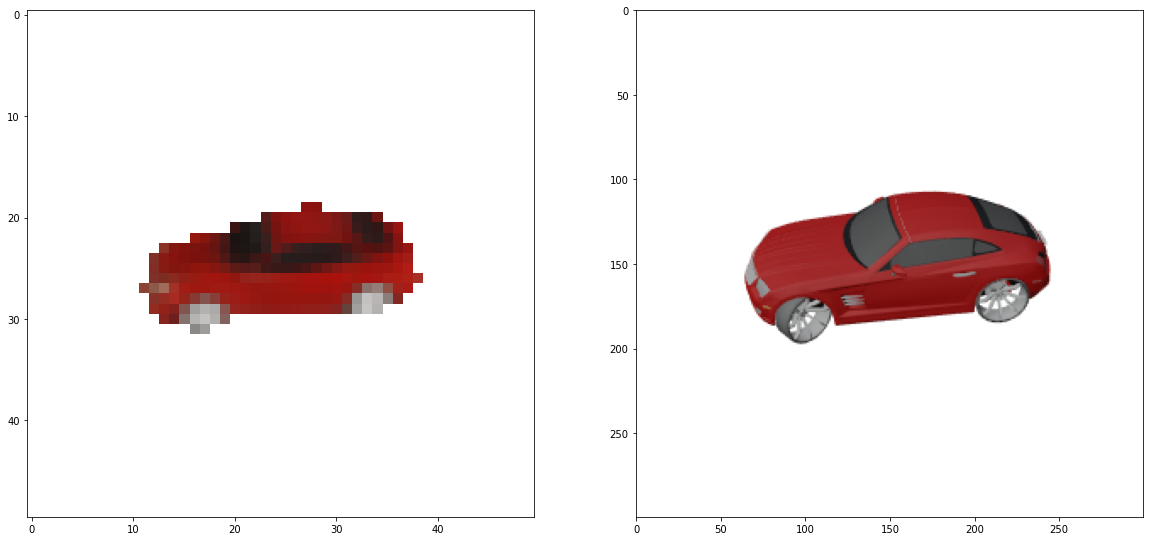

In [8]:

model_id = 3
image_id = 4

threshold = 1/64
max_displacement = 0.1
max_iter = 35
resolution = 50


# load decoder
decoder = torch.load(DECODER_PATH).cuda()
decoder.eval()


model_hash = list_hash[model_id]
code_prediction = latent_code[model_id,:].squeeze()
code_gt = dict_hash_2_code[model_hash].cuda()

frame = annotations[model_hash][image_id]['frame'].copy()
matrix_object_to_world = annotations[model_hash][image_id]['matrix_object_to_world'].copy()
matrix_world_to_camera = pickle.load(open(MATRIX_PATH, 'rb'))

matrix_world_to_camera = matrix_world_to_camera[[1,0,2,3]]
matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]

matrix_camera_to_world = np.linalg.inv(matrix_world_to_camera)
matrix_world_to_object = np.linalg.inv(matrix_object_to_world)

matrix_camera_to_object = matrix_world_to_object.dot(matrix_camera_to_world)

image_pth = IMAGES_PATH + model_hash + '/' + str(image_id) + '.png'
input_im = imageio.imread(image_pth)

cam_pos_cam_coord = np.array([0,0,0,1])
cam_pos_obj_coord = matrix_camera_to_object.dot(cam_pos_cam_coord)

pos_init_ray = np.ones([resolution * resolution, 3])
pos_init_ray[:,0] *= cam_pos_obj_coord[0]
pos_init_ray[:,1] *= cam_pos_obj_coord[1]
pos_init_ray[:,2] *= cam_pos_obj_coord[2]

ray_casting_vector = np.empty([resolution * resolution, 3])

time_start = time.time()

min_step_all = torch.zeros([resolution * resolution]).cuda()
max_step_all = torch.zeros([resolution * resolution]).cuda()

for i in range(resolution):
    for j in range(resolution):

        # select pixel to render
        pixel_pos = np.array([i/(resolution-1),j/(resolution-1)])

        # convert pixel in world coordinate
        pixel_pos_cam_coord = convert_view_to_camera_coordinates(frame, pixel_pos)
        pixel_pos_obj_coord = matrix_camera_to_object.dot(pixel_pos_cam_coord)

        direction = ((pixel_pos_obj_coord - cam_pos_obj_coord)/np.linalg.norm(pixel_pos_obj_coord - cam_pos_obj_coord))[:3]
        ray_casting_vector[i * resolution + j,:] = direction

        bound_max_cube = 0.5
        bound_min_cube = -0.5

        min_step = 0
        max_step = 1e38

        for xyz in range(3):
            if direction[xyz] > 0:
                max = (bound_max_cube - pos_init_ray[i * resolution + j, xyz]) / direction[xyz]
                min = (bound_min_cube - pos_init_ray[i * resolution + j, xyz]) / direction[xyz]

            elif direction[xyz] < 0:
                min = (bound_max_cube - pos_init_ray[i * resolution + j, xyz]) / direction[xyz]
                max = (bound_min_cube - pos_init_ray[i * resolution + j, xyz]) / direction[xyz]
            else:
                if pos_init_ray[i * resolution + j, xyz] < bound_min_cube or pos_init_ray[i * resolution + j, xyz] > bound_max_cube:
                    continue

            if min > min_step:
                min_step = min
            if max < max_step:
                max_step = max

        if min_step < max_step:
            # pos_init_ray[i * resolution + j, :] = pos_init_ray[i * resolution + j, :] + min_step * direction
            min_step_all[i * resolution + j] = min_step
            max_step_all[i * resolution + j] = max_step
            


ray_casting_vector = torch.tensor(ray_casting_vector,dtype=torch.float).cuda()
pos_init_ray = torch.tensor(pos_init_ray,dtype=torch.float).cuda()


min_pos = pos_init_ray + min_step_all.unsqueeze(1).mul(ray_casting_vector)
max_pos = pos_init_ray + max_step_all.unsqueeze(1).mul(ray_casting_vector)


print(f"time for initialization: {time.time() - time_start}")
time_start = time.time()

nb_interp = 21
idx = np.array([0,0.2,0.26,0.29,0.32,0.35,0.38,0.41,0.44,0.47,0.5,0.53,0.56,0.59,0.62,0.65,0.68,0.71,0.74,0.8, 1])
grid = torch.empty(nb_interp, resolution * resolution, 3).cuda()

for i in range(nb_interp):
    # grid[i] = torch.lerp(min_pos, max_pos, i / (nb_interp - 1))
    grid[i] = torch.lerp(min_pos, max_pos, idx[i])

grid_input = grid.reshape(nb_interp * resolution* resolution, 3)

sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution * nb_interp,1]), grid_input).detach()
sdf = sdf_and_rgb[:,0].reshape(nb_interp, resolution * resolution)


intersection_idx = torch.zeros(resolution * resolution, dtype=torch.long).cuda()
for i in range(nb_interp):
    intersection_idx[(sdf[i] < 0) * (intersection_idx == 0)] = i

for i in range(resolution * resolution):
    if intersection_idx[i] != 0:
        min_pos[i] = grid[intersection_idx[i] - 1, i, :]
        max_pos[i] = grid[intersection_idx[i], i, :]

for i in range(nb_interp):
    grid[i] = torch.lerp(min_pos, max_pos, i / (nb_interp - 1))
    # grid[i] = torch.lerp(min_pos, max_pos, idx[i])

grid_input = grid.reshape(nb_interp * resolution* resolution, 3)


sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution * nb_interp,1]), grid_input).detach()


sdf = sdf_and_rgb[:,0].reshape(nb_interp, resolution * resolution)


nb_interp = 20
intersection_idx = torch.zeros(resolution * resolution, dtype=torch.long).cuda()
for i in range(nb_interp):
    intersection_idx[(sdf[i] < 0) * (intersection_idx == 0)] = i

sdf_and_rgb_prediction = torch.empty([resolution * resolution, 4], dtype=torch.float).cuda()
for i in range(resolution * resolution):
    sdf_and_rgb_prediction[i] = sdf_and_rgb[i + resolution * resolution * (intersection_idx[i] - 1)]


car_mask = sdf_and_rgb_prediction[:,0] < threshold
sdf_and_rgb_prediction = sdf_and_rgb_prediction.reshape(resolution, resolution, 4).cpu().numpy()
sdf = sdf_and_rgb_prediction[:,:,0]
rgb = sdf_and_rgb_prediction[:,:,1:]

rendered_image = np.ones([resolution,resolution,3])
rendered_image[sdf < threshold] = rgb[sdf < threshold]

### show cube
# cube_mask = min_step_all.reshape(resolution, resolution).cpu().numpy() == 0
# rendered_image[cube_mask] = np.zeros(3)


print(f"time for rendering: {time.time() - time_start}")
time_start = time.time()
        


image_upscaled2 = cv2.resize(rendered_image, (100,100))
# rendered_image_ray_marching = cv2.resize(rendered_image_ray_marching, (100,100))

fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].imshow(rendered_image)
# axs[1].imshow(image_upscaled2)
# axs[2].imshow(rendered_image_ray_marching)
axs[1].imshow(input_im)


print(f"pixel mask of the car: {car_mask.count_nonzero()}")



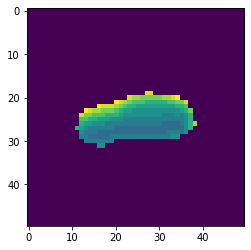

In [100]:
test = intersection_idx.reshape(resolution, resolution).cpu().numpy()
plt.imshow(test)

In [89]:
sdf_and_rgb_prediction.shape

(50, 50, 4)

In [355]:
grid_input.shape

torch.Size([52500, 3])

In [460]:
time_start = time.time()
for i in range(nb_interp):
    sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution * 1,1]), grid_input[ : resolution * resolution]).detach()

sdf_and_rgb[0,0].cpu()
print(f"time for decoding: {time.time() - time_start}")

time for decoding: 0.10049271583557129


In [448]:
time_start = time.time()
sdf_and_rgb = decoder(code_prediction.unsqueeze(0).repeat([resolution * resolution * nb_interp,1]), grid_input).detach()

sdf_and_rgb[0,0].cpu()
print(f"time for decoding: {time.time() - time_start}")

time for decoding: 0.09473514556884766


In [359]:
grid_input[:resolution * resolution].shape

torch.Size([2500, 3])